## 1. Importing Libraries & Load the file

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Reading Dataset
data = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [4]:
# Checking Shape of data
data.shape

(35887, 3)

## 2. Data Visualization

In [5]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
label_to_text

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral'}

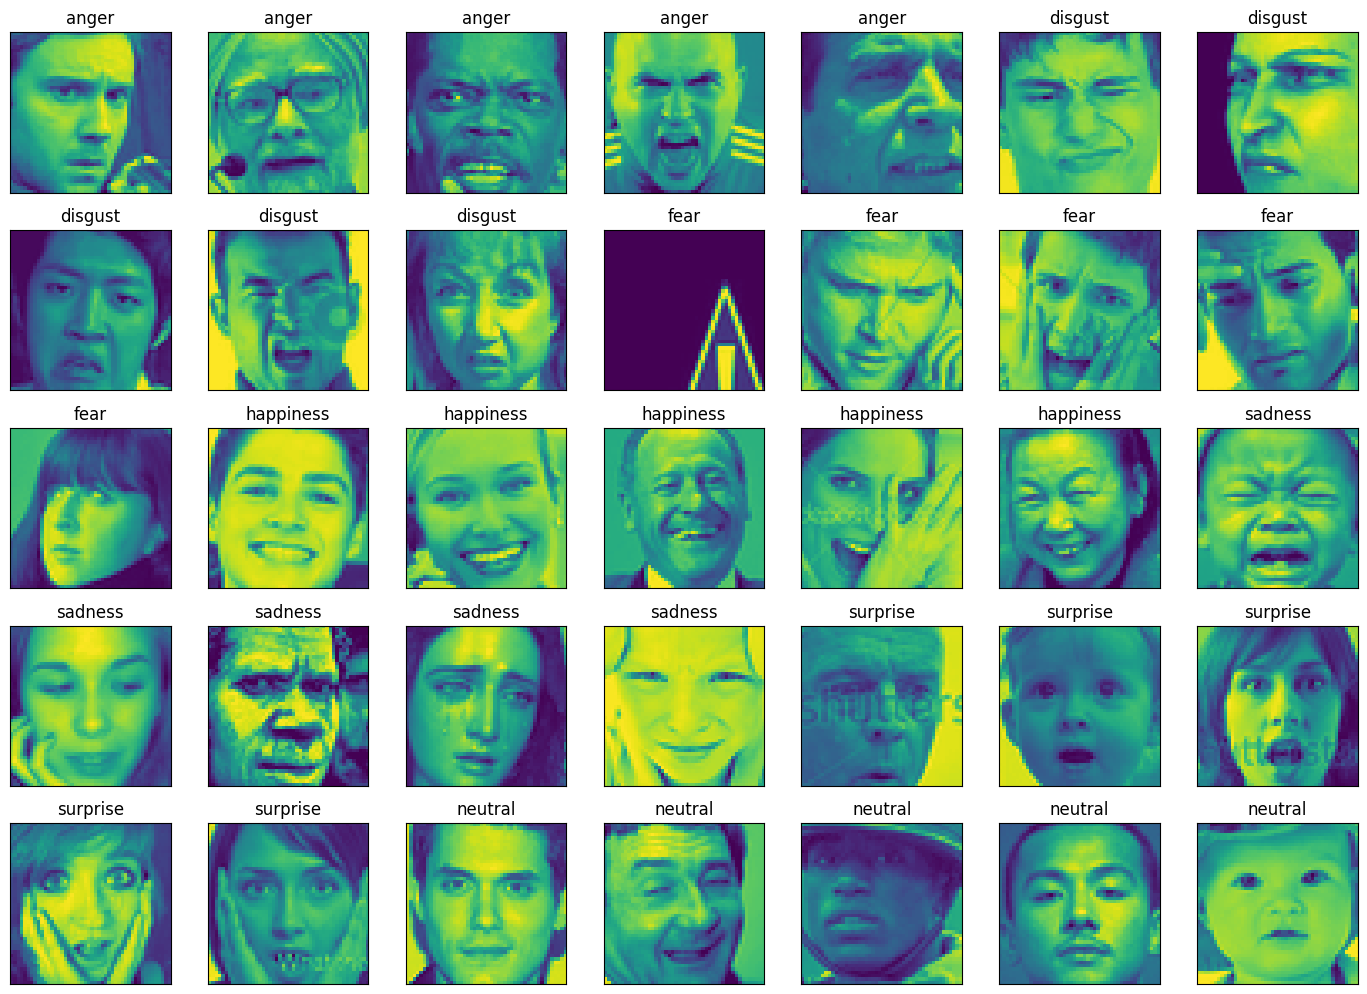

In [6]:
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(data.emotion.unique()):
    for j in range(5):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

In [7]:
# Checking Emotion Class Distribution
data['emotion'].value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


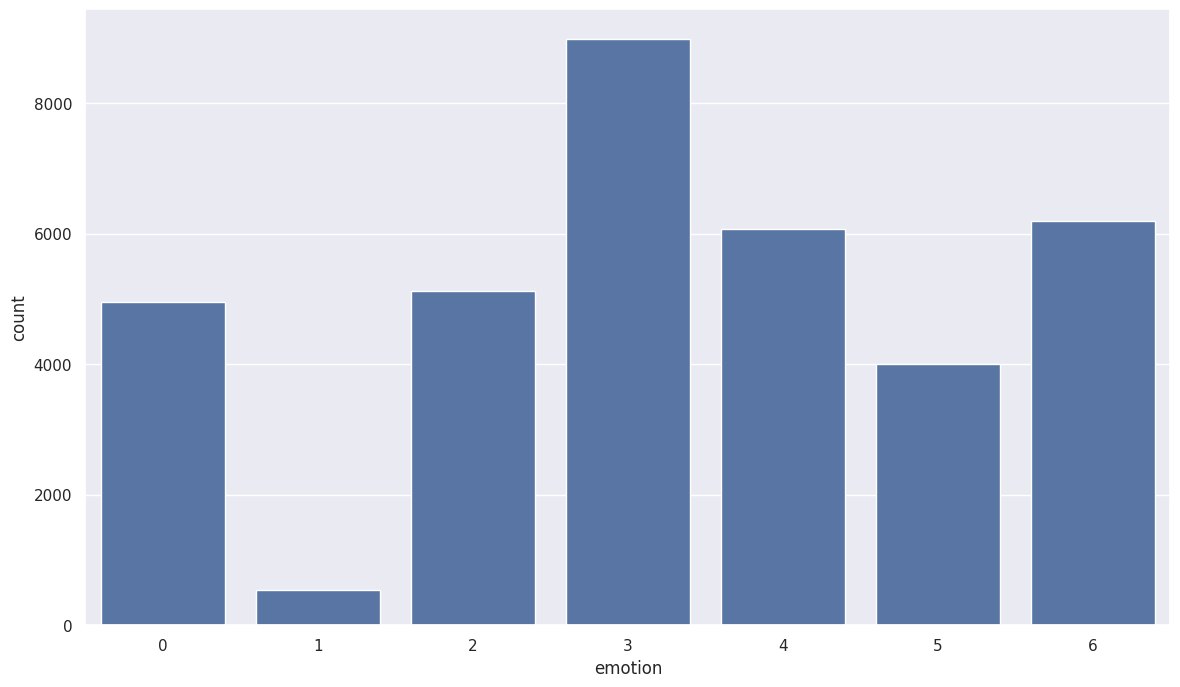

In [8]:
# Plotting the above distribution
plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

*From the above chart, we can observe that the data is highly imbalnace and for some emotions we have very small number of images, so we need to balnce the data by oversampling technique, so to that enough number of images for every emotions(class).*

## 3. Data Pre-processing (Balancing & Preparation)

In [9]:
# Split the data into feature & target variable
x_data = data['pixels']
y_data = data['emotion']

In [10]:
# Perform Random Over Sampling to balance the data
oversampler = RandomOverSampler(sampling_strategy='auto')
x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [11]:
# Let's check the distributio of target data again after balancing
y_data.value_counts()

,count
emotion,
0,8989
2,8989
4,8989
6,8989
3,8989
5,8989
1,8989


In [12]:
x_data = pd.Series(x_data.flatten())
x_data

,0
0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,151 150 147 155 148 133 111 140 170 174 182 15...
2,231 212 156 164 174 138 161 173 182 200 106 38...
3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...
62918,225 228 228 229 231 230 237 199 74 80 95 107 1...
62919,32 50 68 82 91 104 117 126 137 147 155 163 167...
62920,130 130 135 114 82 105 138 139 104 47 32 28 19...
62921,83 95 89 86 82 99 103 85 101 92 78 74 87 83 62...


In [13]:
# Normalize the data
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [14]:
# Reshaping
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [15]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [16]:
# Split the data and create train-test set
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [17]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 1), (6293, 1))

In [18]:
# Perform One-Hot Encoding on training data
y_train = to_categorical(y_train, 7)
y_train.shape

(56630, 7)

In [19]:
# Perform One-Hot Encoding on test data
y_test = to_categorical(y_test, 7)
y_test.shape

(6293, 7)

## 4. Model Building

In [20]:
model = Sequential([
    # 1st Conv Layer
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 2nd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 3rd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 4th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 5th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Flattening the Layer
    Flatten(),

    # Hidden Layer
    Dense(250, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(7, activation = 'softmax')
])

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 250)            │       512,250 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 792,855 (3.02 MB)

 Trainable params: 792,023 (3.02 MB)

 Non-trainable params: 832 (3.25 KB)

## 5. Model Training

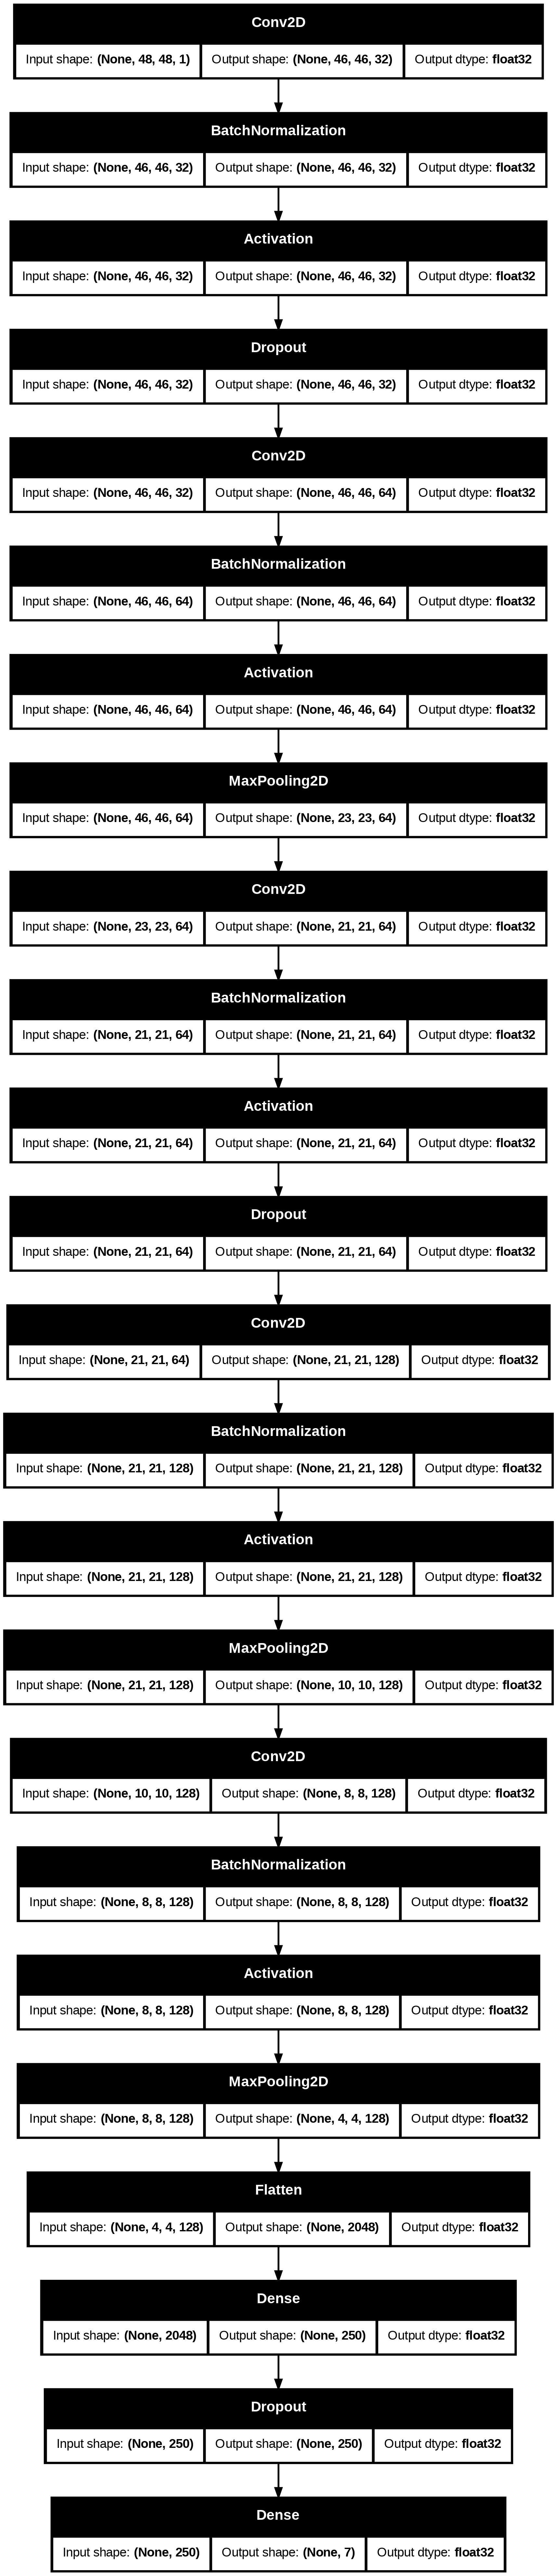

In [22]:
# Model Flowchart
tf.keras.utils.plot_model(model, to_file = "/content/drive/MyDrive/best_model.png", show_shapes = True, show_dtype = True)

In [23]:
# Compile the Model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Train the Model
history = model.fit(x_train, y_train, epochs = 35, validation_data=(x_test, y_test))

Epoch 1/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8543 - loss: 0.4005 - val_accuracy: 0.8130 - val_loss: 0.5953
Epoch 2/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.8559 - loss: 0.3949 - val_accuracy: 0.8090 - val_loss: 0.6089
Epoch 3/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8651 - loss: 0.3783 - val_accuracy: 0.8177 - val_loss: 0.5879
Epoch 4/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.8658 - loss: 0.3673 - val_accuracy: 0.8219 - val_loss: 0.5764
Epoch 5/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8710 - loss: 0.3586 - val_accuracy: 0.8208 - val_loss: 0.5912
Epoch 6/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8754 - loss: 0.3484 - val_accuracy: 0.8273 - val_loss: 0.5830
Epoch 7/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8749 - loss: 0.3405 - val_accuracy: 0.8184 - val_loss: 0.6226
Epoch 8/35
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.8814 -

## 6. Model Evaluation

In [26]:
print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")
print("Loss of our model on test data : " , model.evaluate(x_test, y_test)[0])

197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8575 - loss: 0.6898
Accuracy of our model on test data :  85.95264554023743 %
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8575 - loss: 0.6898
Loss of our model on test data :  0.6426295042037964


***The test accuracy & loss of our model is 85.96
%
respectively, which is better than many exsited state-of-the-art results.***

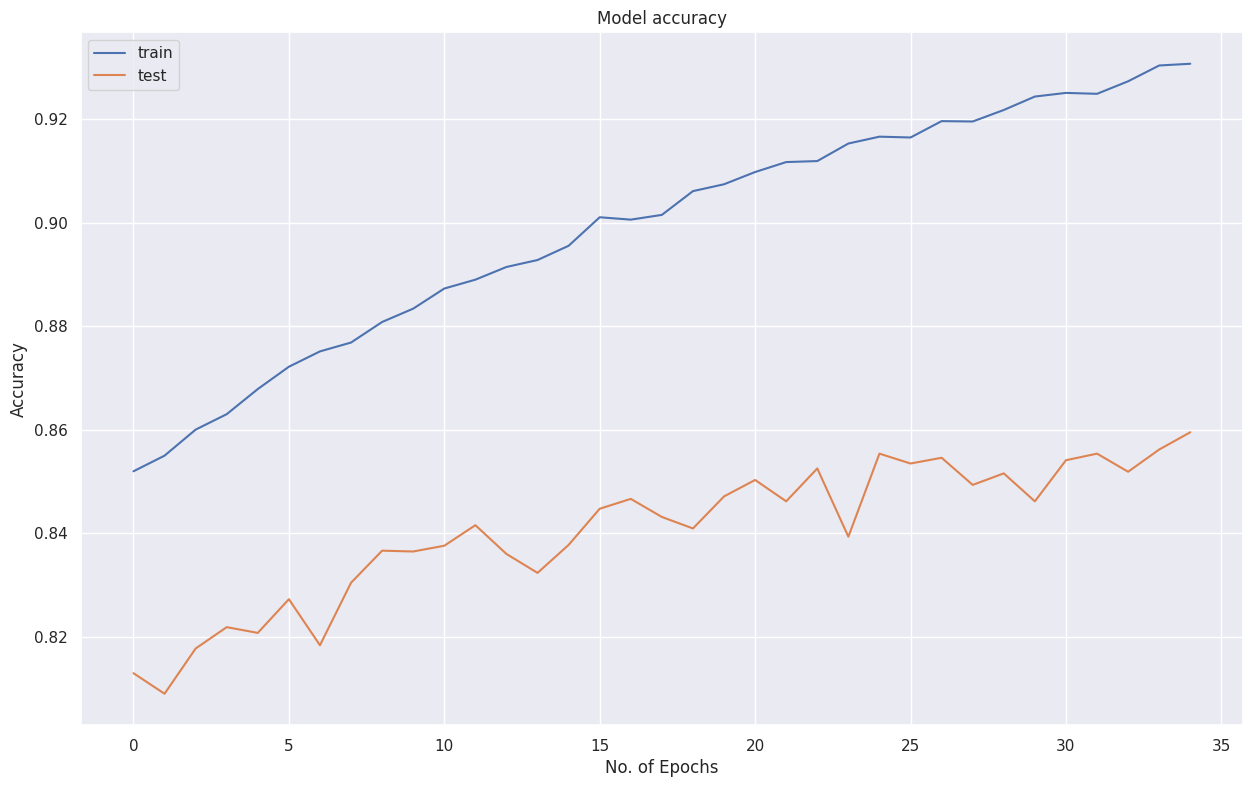

In [27]:
plt.figure(figsize=(15, 9))

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

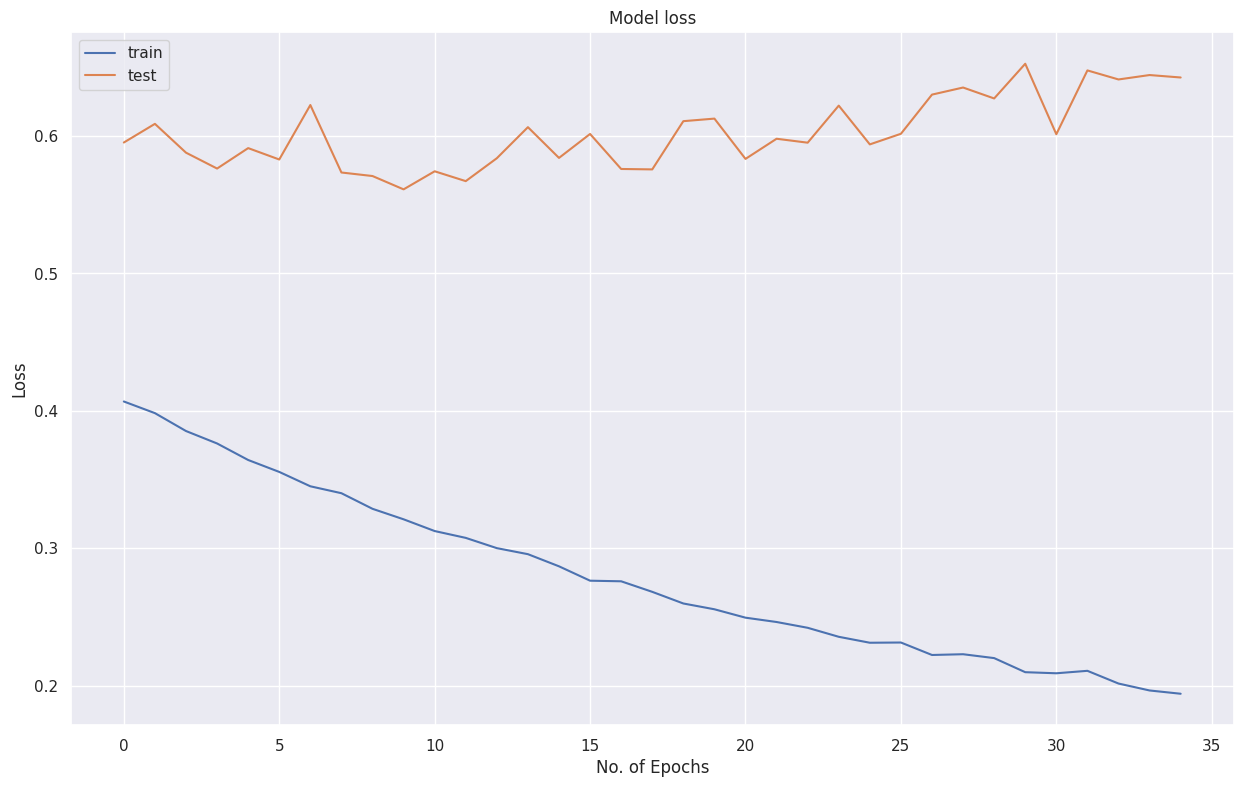

In [28]:
plt.figure(figsize=(15, 9))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 7. Getting Classification Report & Plotting Confusion Matrix

In [29]:
# Making Predictio on Test Data
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


[np.int64(6),
 np.int64(5),
 np.int64(5),
 np.int64(6),
 np.int64(1),
 np.int64(0),
 np.int64(3),
 np.int64(4),
 np.int64(1),
 np.int64(6)]

In [30]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[np.int64(6),
 np.int64(5),
 np.int64(5),
 np.int64(6),
 np.int64(1),
 np.int64(0),
 np.int64(3),
 np.int64(4),
 np.int64(1),
 np.int64(3)]

In [31]:
# Getting Classification Report
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       935
           1       0.99      1.00      1.00       895
           2       0.85      0.80      0.82       880
           3       0.88      0.81      0.85       906
           4       0.77      0.76      0.77       888
           5       0.90      0.96      0.93       869
           6       0.75      0.83      0.79       920

    accuracy                           0.86      6293
   macro avg       0.86      0.86      0.86      6293
weighted avg       0.86      0.86      0.86      6293



Text(178.75, 0.5, 'Truth')

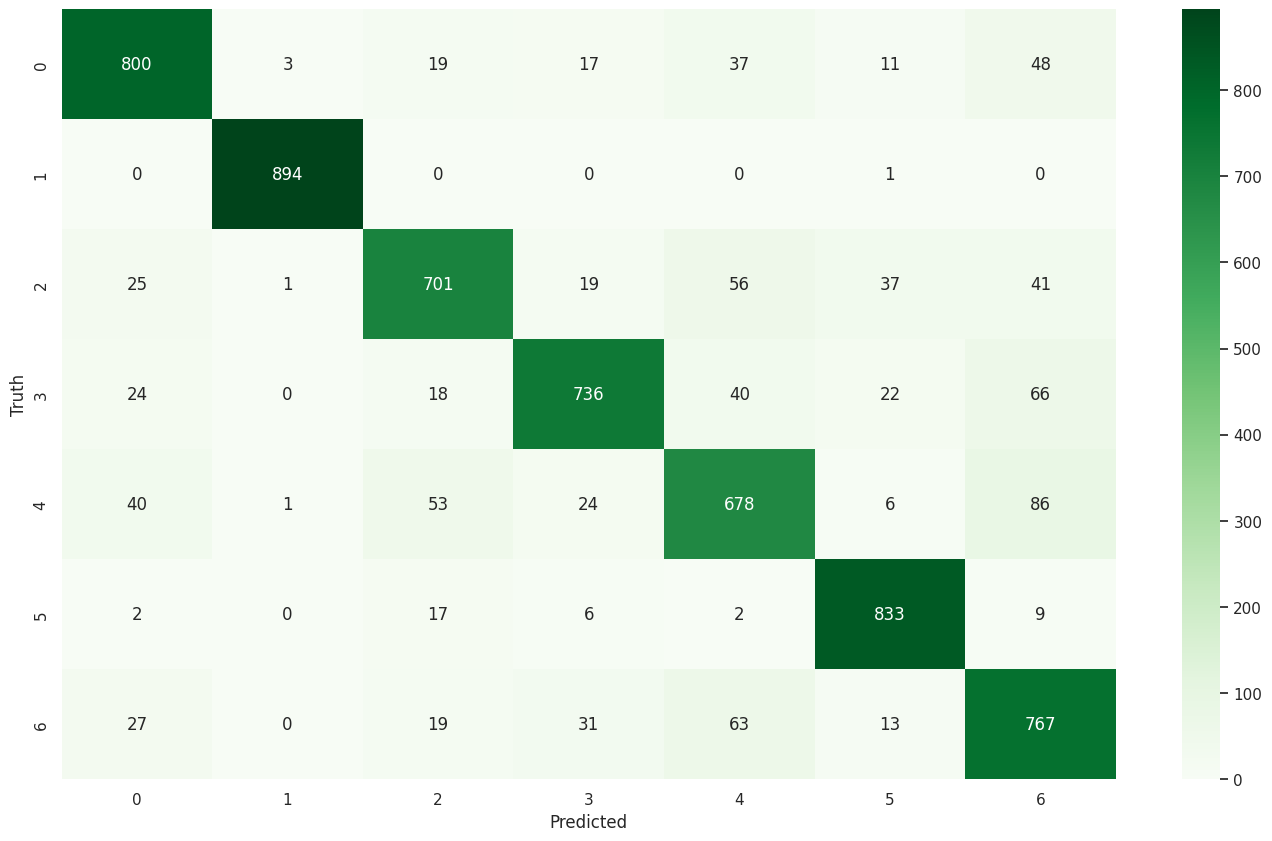

In [32]:
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (17, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Truth')

## **8. Save the Model**

In [33]:
# Save the Model
model.save("/content/drive/MyDrive/Final_Expression.hdf5")

In [34]:
# Save the model in the native Keras format
model.save("/content/drive/MyDrive/Final_Expression.keras")

In [35]:
#Saving the  model to  use it later on
fer_json = model.to_json()
with open("/content/drive/MyDrive/Final_Expression.json", "w") as json_file:
    json_file.write(fer_json)


In [36]:
model.save_weights("fer.weights.h5")